In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

### Ratings file
Each line contains a rated video game:

- a user
- an item
- a rating from 1 to 5

In [31]:
raw_ratings = pd.read_csv('ratings_latest.csv', sep=',')

raw_ratings.head()

,id,rate,appid
0,76561197960265729,1.0,10
1,76561197960265729,1.0,20
2,76561197960265729,1.0,30
3,76561197960265729,1.0,40
4,76561197960265729,1.0,50


### Metadata file

This file contains information about each game, specifically:
- item
- name
- genres

In [32]:
items = pd.read_csv('metadata.csv', sep=',')

items.head()

,appid,appname,genres
0,10,Counter-Strike,1/
1,20,Team Fortress Classic,1/
2,30,Day of Defeat,1/
3,40,Deathmatch Classic,1/
4,50,Half-Life: Opposing Force,1/


In [33]:
all_ratings = pd.merge(items, raw_ratings)

all_ratings.head()

,appid,appname,genres,id,rate
0,10,Counter-Strike,1/,76561197960265729,1.00
1,10,Counter-Strike,1/,76561197960265730,2.05
2,10,Counter-Strike,1/,76561197960265731,1.00
3,10,Counter-Strike,1/,76561197960265733,1.40
4,10,Counter-Strike,1/,76561197960265734,1.00


### Data pre-analysis
Survey the data and analyze its distribution and statistics. The following are computed:

- number of users
- number of items
- rating distribution

In [34]:
all_ratings['rate'].describe()

count    2.573393e+07
mean     1.275410e+00
std      7.960212e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.100000e+00
max      5.950000e+00
Name: rate, dtype: float64

#### Maximum Stats

In [35]:
print(all_ratings['id'].value_counts().index.tolist()[0])
print(all_ratings['id'].value_counts().tolist()[0])

76561197973009892
10440


User 76561197973009892 contains the most games in our dataset, with more than 10440 ratings.

In [36]:
print(all_ratings['appid'].value_counts().index.tolist()[0])
print(all_ratings['appid'].value_counts().tolist()[0])

340
364650


Game 15 has the most ownerships, with 364.650 owners, or about 53.89% of our user dataset.

#### User Game Statistics

In [37]:
users_nb = all_ratings['id'].value_counts().reset_index()
users_nb.columns= ['id','nb_lines']
users_nb['nb_lines'].describe()

count    676668.000000
mean         38.030361
std         123.929002
min           1.000000
25%           4.000000
50%           8.000000
75%          22.000000
max       10440.000000
Name: nb_lines, dtype: float64

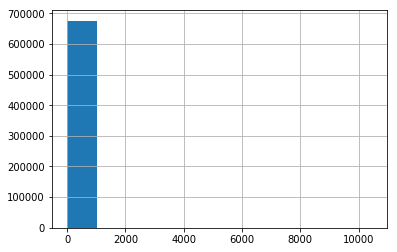

In [38]:
import seaborn
users_nb['nb_lines'].hist()

Half the user dataset owns not more than 8 games.

#### Game ownership stats

In [39]:
games_nb = all_ratings['appid'].value_counts().reset_index()
games_nb.columns= ['appid','nb_lines']
games_nb['nb_lines'].describe()

count     18865.000000
mean       1364.109621
std        8333.452088
min           1.000000
25%          13.000000
50%          86.000000
75%         510.000000
max      364650.000000
Name: nb_lines, dtype: float64

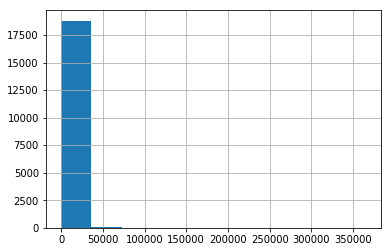

In [40]:
games_nb['nb_lines'].hist()

Half of the game dataset has no more than 86 ownerships

### Data pre-processing

In [41]:
users = all_ratings.id.unique()
user_map = {i:val for i,val in enumerate(users)}
inverse_user_map = {val:i for i,val in enumerate(users)}


games = all_ratings.appid.unique()
game_map = {i:val for i,val in enumerate(games)}
inverse_game_map = {val:i for i,val in enumerate(games)}

all_ratings["id"] = all_ratings["id"].map(inverse_user_map)

all_ratings["old_id"] = all_ratings["appid"] # copying for join with metadata
all_ratings["appid"] = all_ratings["appid"].map(inverse_game_map)

print ("A total of: ", users.shape[0], "unique users")
print ("A total of: ", games.shape[0], "unique games")

A total of:  676668 unique users
A total of:  18865 unique games


In [42]:
all_ratings.sort_values('rate', ascending=False).head(10)

,appid,appname,genres,id,rate,old_id
543073,2,Day of Defeat,1/,100887,5.95,30
2433028,11,Counter-Strike: Source,1/,364830,5.95,240
13934442,1625,Football Manager 2013™,28/18/,560547,5.95,207890
25295968,13817,PLAYERUNKNOWN'S BATTLEGROUNDS,73/1/25/29/,475864,5.95,578080
6266506,283,BioShock Infinite,1/,428206,5.95,8870
23728290,8791,Raw Data,1/23/2/,280654,5.95,436320
6827805,333,Call of Duty®: Modern Warfare® 2,1/,446221,5.95,10190
24754130,11471,Panzer Warfare,1/4/23/29/28/2/70/,358534,5.95,513880
9434766,811,Arma 2: Operation Arrowhead,1/28/2/,404183,5.95,33930
18807596,2846,XCOM® 2,2/,45380,5.95,268500


In [43]:
from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(
    all_ratings, test_size=0.2, random_state=0)

In [44]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction 
config.gpu_options.visible_device_list = "0" # "0,1"
set_session(tf.Session(config=config))

In [45]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import pydot

In [46]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Reshape, Dropout, Dense
from keras.layers.merge import Multiply, Dot
from keras.layers.embeddings import Embedding
from keras.layers.merge import Concatenate
from keras import optimizers
from keras.optimizers import Adam

In [47]:
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 10 # 5
user_embedding = Embedding(output_dim=embedding_size, input_dim=users.shape[0],
                           input_length=1, name='user_embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=games.shape[0],
                           input_length=1, name='item_embedding')(item_id_input)

user_vecs = Reshape([embedding_size])(user_embedding)
item_vecs = Reshape([embedding_size])(item_embedding)

input_vecs = Concatenate()([user_vecs, item_vecs])

input_vecs = Dropout(0.3)(input_vecs)
x = Dense(70, activation='relu')(input_vecs)
# x = Dense(128, activation='relu')(x)
x = Dropout(0.75)(x)
y = Dense(1)(x)


model = Model(inputs=[user_id_input, item_id_input], outputs=y)
# model.compile(optimizer='adam', loss='mse')
model.compile(Adam(0.001), loss='mse')

In [48]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

initial_train_preds = model.predict([ratings_train["id"], ratings_train["appid"]])
print("Initial train MSE: %0.3f" % mean_squared_error(initial_train_preds, ratings_train["rate"]))
print("Initial train MAE: %0.3f" % mean_absolute_error(initial_train_preds, ratings_train["rate"]))

Initial train MSE: 2.279
Initial train MAE: 1.283


In [49]:
initial_test_preds = model.predict([ratings_test["id"], ratings_test["appid"]])
print("Initial test MSE: %0.3f" % mean_squared_error(initial_test_preds, ratings_test["rate"]))
print("Initial test MAE: %0.3f" % mean_absolute_error(initial_test_preds, ratings_test["rate"]))

Initial test MSE: 2.281
Initial test MAE: 1.283


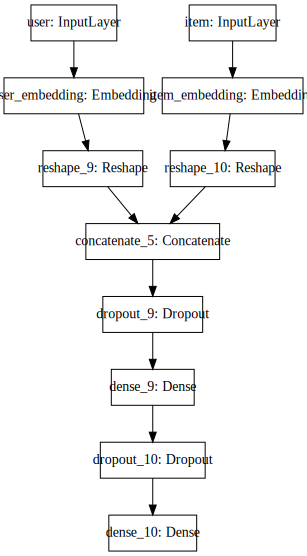

In [50]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [51]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        6766680     user[0][0]                       
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        188650      item[0][0]                       
__________________________________________________________________________________________________
reshape_9 

In [52]:
# initial_train_preds_nn = model.predict([ratings_train["id"], ratings_train["appid"]])

In [53]:
%%time

history = model.fit([ratings_train["id"], ratings_train["appid"]]
                    , ratings_train["rate"]
                    , validation_data = ([ratings_test["id"], ratings_test["appid"]], ratings_test["rate"])
                    , batch_size=64, epochs=20
                    , validation_split=0.1
                    , verbose = 2
                    , shuffle=True)


Train on 20587142 samples, validate on 5146786 samples
Epoch 1/20
 - 38053s - loss: 0.4389 - val_loss: 0.4042
Epoch 2/20
 - 37759s - loss: 0.4154 - val_loss: 0.4002
Epoch 3/20
 - 37830s - loss: 0.4066 - val_loss: 0.3967
Epoch 4/20
 - 37685s - loss: 0.4011 - val_loss: 0.4025
Epoch 5/20
 - 37787s - loss: 0.3978 - val_loss: 0.3986
Epoch 6/20
 - 37753s - loss: 0.3951 - val_loss: 0.3995
Epoch 7/20
 - 37662s - loss: 0.3929 - val_loss: 0.4052
Epoch 8/20
 - 37582s - loss: 0.3912 - val_loss: 0.4034
Epoch 9/20
 - 37692s - loss: 0.3900 - val_loss: 0.4028
Epoch 10/20
 - 37919s - loss: 0.3891 - val_loss: 0.4071
Epoch 11/20
 - 37669s - loss: 0.3883 - val_loss: 0.4076
Epoch 12/20
 - 37592s - loss: 0.3880 - val_loss: 0.4033
Epoch 13/20
 - 39267s - loss: 0.3871 - val_loss: 0.4028
Epoch 14/20
 - 38407s - loss: 0.3864 - val_loss: 0.4046
Epoch 15/20
 - 37487s - loss: 0.3860 - val_loss: 0.4080
Epoch 16/20
 - 39041s - loss: 0.3856 - val_loss: 0.4119
Epoch 17/20
 - 37359s - loss: 0.3857 - val_loss: 0.4103
Ep

In [54]:
import pickle

with open('dense70.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
loss,0.438926,0.415372,0.40656,0.401054,0.397784,0.395111,0.392864,0.391222,0.389958,0.389102,0.388287,0.387991,0.387057,0.386362,0.386012,0.385635,0.385662,0.385306,0.385104,0.385151
val_loss,0.404163,0.400179,0.39673,0.402464,0.398603,0.399531,0.405217,0.403373,0.402757,0.407068,0.407623,0.403302,0.402815,0.404582,0.408002,0.411909,0.410331,0.405127,0.406132,0.411312


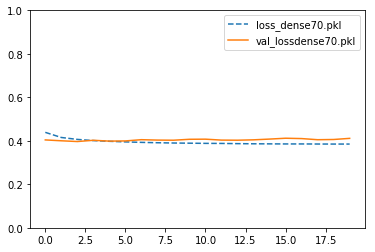

In [55]:
histories = ['dense70.pkl']

import pickle
for val in histories:
    with open(val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
plt.legend()
plt.ylim(0, 1)

pd.DataFrame(thepickle,columns =['loss','val_loss']).head(20).transpose()

In [56]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

train_preds = model.predict([ratings_train["id"], ratings_train["appid"]])
print("Final train MSE: %0.3f" % mean_squared_error(train_preds, ratings_train["rate"]))
print("Final train MAE: %0.3f" % mean_absolute_error(train_preds, ratings_train["rate"]))

Final train MSE: 0.353
Final train MAE: 0.261


In [57]:
test_preds = model.predict([ratings_test["id"], ratings_test["appid"]])
print("Final train MSE: %0.3f" % mean_squared_error(test_preds, ratings_test["rate"]))
print("Final train MAE: %0.3f" % mean_absolute_error(test_preds, ratings_test["rate"]))

Final train MSE: 0.411
Final train MAE: 0.281


In [59]:
model.save('dense70.h5')

In [60]:
loss = model.evaluate([ratings_test["id"], ratings_test["appid"]], ratings_test["rate"])

5146786/5146786 [==============================] - 114s 22us/step


In [61]:
print(loss)

0.411312131531


### Experimenting with recurrent layers

In [58]:
from keras.layers.recurrent import GRU, LSTM


user_id_input_gru = Input(shape=[1], name='user')
item_id_input_gru = Input(shape=[1], name='item')

embedding_size = 10 # 5
user_embedding_gru = Embedding(output_dim=embedding_size, input_dim=users.shape[0],
                           input_length=1, name='user_embedding')(user_id_input_gru)
item_embedding_gru = Embedding(output_dim=embedding_size, input_dim=games.shape[0],
                           input_length=1, name='item_embedding')(item_id_input_gru)

user_vecs = Reshape([embedding_size])(user_embedding_gru)
item_vecs = Reshape([embedding_size])(item_embedding_gru)

input_vecs = Concatenate()([user_vecs, item_vecs])

input_vecs = Dropout(0.3)(input_vecs)
x = GRU(70)(input_vecs)

x = Dropout(0.75)(x)
y = Dense(1)(x)


model_GRU = Model(inputs=[user_id_input, item_id_input], outputs=y)
# model.compile(optimizer='adam', loss='mse')
model_GRU.compile(Adam(0.001), loss='mse')

ValueError: Input 0 is incompatible with layer gru_1: expected ndim=3, found ndim=2

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

initial_train_preds_gru = model.predict([ratings_train["id"], ratings_train["appid"]])
print("Initial train MSE: %0.3f" % mean_squared_error(initial_train_preds_gru, ratings_train["rate"]))
print("Initial train MAE: %0.3f" % mean_absolute_error(initial_train_preds_gru, ratings_train["rate"]))

In [ ]:
initial_test_preds_gru = model.predict([ratings_test["id"], ratings_test["appid"]])
print("Initial test MSE: %0.3f" % mean_squared_error(initial_test_preds_gru, ratings_test["rate"]))
print("Initial test MAE: %0.3f" % mean_absolute_error(initial_test_preds_gru, ratings_test["rate"]))

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
model_GRU.summary()

In [ ]:
%%time

history = model_GRU.fit([ratings_train["id"], ratings_train["appid"]]
                    , ratings_train["rate"]
                    , validation_data = ([ratings_test["id"], ratings_test["appid"]], ratings_test["rate"])
                    , batch_size=64, epochs=20
                    , validation_split=0.1
                    , verbose = 2
                    , shuffle=True)

In [ ]:
import pickle

with open('gru70.pkl' , 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
histories = ['gru70.pkl']

import pickle
for val in histories:
    with open(val , 'rb') as file_pi:
        thepickle = pickle.load(file_pi)
        plt.plot(thepickle["loss"],label ='loss_' + val,linestyle='--')
        plt.plot(thepickle["val_loss"],label='val_loss' + val)
plt.legend()
plt.ylim(0, 1)

pd.DataFrame(thepickle,columns =['loss','val_loss']).head(20).transpose()